In [83]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

##############################
# 1) LOAD ANNOTATIONS & CONN
##############################
df_anno = pd.read_csv("./data/science.add9330_data_s2.csv")
df_conn = pd.read_csv("./data/ad_connectivity_matrix.csv", index_col=0)

# Make sure columns/rows are integer IDs:
df_conn.index = df_conn.index.astype(int)
df_conn.columns = df_conn.columns.astype(int)

# For simplicity, filter out rows where 'right_id' is not numeric
def is_valid_id(x):
    try:
        int(x)
        return True
    except:
        return False

df_anno = df_anno[df_anno['right_id'].apply(is_valid_id)]
df_anno['right_id'] = df_anno['right_id'].astype(int)

# Mark "visual" if "visual" appears in additional_annotations
def is_visual(annotation_str):
    return "visual" in str(annotation_str).lower()
df_anno['is_visual'] = df_anno['additional_annotations'].apply(is_visual)

# Build sets
all_ids_in_matrix = set(df_conn.index)
visual_ids = set(df_anno.loc[df_anno['is_visual'], 'right_id']) & all_ids_in_matrix
brain_ids = all_ids_in_matrix - visual_ids  # everything else

print(f"Found {len(visual_ids)} visual IDs, {len(brain_ids)} brain IDs")

# Slice submatrices: rows=receiver, columns=sender
W_in_df = df_conn.loc[list(brain_ids), list(visual_ids)]   # shape => [#brain, #visual]
W_rec_df = df_conn.loc[list(brain_ids), list(brain_ids)]    # shape => [#brain, #brain]

# Convert to numpy
W_in_raw = W_in_df.values  # shape (2927, 25) e.g.
W_rec_raw = W_rec_df.values  # shape (2927, 2927)

# If we want them in the typical (input_size, hidden_size) format => transpose W_in
W_in_init = W_in_raw.T    # shape => [25, 2927]
W_rec_init = W_rec_raw    # shape => [2927, 2927] (fine as-is, row = old hidden, col = next hidden)




Found 25 visual IDs, 2927 brain IDs


In [84]:
import pandas as pd
import numpy as np

def is_valid_id(x):
    try:
        int(x)
        return True
    except:
        return False

def load_connectome_and_split(
    anno_file='./data/science.add9330_data_s2.csv',
    conn_file='./data/ad_connectivity_matrix.csv'
):
    # 读取注释表
    df_anno = pd.read_csv(anno_file)
    df_anno = df_anno[df_anno['right_id'].apply(is_valid_id)].copy()
    df_anno['right_id'] = df_anno['right_id'].astype(int)

    # 筛选 "visual" 或 "visual 2nd_order" 关键词
    def is_visual(a):
        s = str(a).lower()
        return ("visual" in s)  # 简单判断

    df_anno['is_visual'] = df_anno['additional_annotations'].apply(is_visual)

    # 提取 visual 子集 ID
    visual_ids = set(df_anno.loc[df_anno['is_visual'], 'right_id'])

    # 读取连接矩阵
    df_conn = pd.read_csv(conn_file, index_col=0)
    df_conn.index = df_conn.index.astype(int)
    df_conn.columns = df_conn.columns.astype(int)

    # 全部 ID
    all_ids = set(df_conn.index)
    # 除去视觉神经元，其余视为 brain
    brain_ids = all_ids - visual_ids

    # 只保留真实交集，防止注释表里有而矩阵里没有
    visual_ids = list(visual_ids & all_ids)
    brain_ids = list(brain_ids)

    # 切分子矩阵
    # W_in: brain 行 × visual 列
    W_in_df = df_conn.loc[brain_ids, visual_ids]
    W_in = W_in_df.values  # shape [len(brain_ids), len(visual_ids)]

    # W_rec: brain 行 × brain 列
    W_rec_df = df_conn.loc[brain_ids, brain_ids]
    W_rec = W_rec_df.values  # shape [len(brain_ids), len(brain_ids)]

    return W_in, W_rec, visual_ids, brain_ids


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConnectomeRNN(nn.Module):
    def __init__(self,
                 W_in_init,    # numpy数组, shape [brain_size, 25] 或 [25, brain_size]
                 W_rec_init,   # numpy数组, shape [brain_size, brain_size]
                 brain_size=2927,
                 visual_size=25,
                 output_size=10,
                 num_steps=10):
        super().__init__()
        
        self.input_size = 784           # MNIST展平后784
        self.visual_size = visual_size  # 从connectome看是25
        self.hidden_size = brain_size   # 例如2927
        self.output_size = output_size
        self.num_steps = num_steps

        # 预处理层: 784 -> 25
        self.preprocess = nn.Linear(self.input_size, self.visual_size)

        # 处理 W_in (从CSV读取的 connectome子矩阵)
        W_in_torch = torch.tensor(W_in_init, dtype=torch.float32)
        W_min, W_max = W_in_torch.min(), W_in_torch.max()
        W_in_norm = (W_in_torch - W_min) / (W_max - W_min + 1e-8)
        # 如果是 [brain_size, visual_size]，则要转置成 [visual_size, brain_size] 才能 x @ self.W_in
        if W_in_norm.shape == (self.hidden_size, self.visual_size):
            W_in_norm = W_in_norm.transpose(0, 1)  # 变成 [25, 2927]
        # 最终要求 W_in 为 [25, 2927] (visual_size, brain_size)
        self.W_in = torch.tensor(W_in_norm, requires_grad=False)

        # 处理 W_rec (脑内循环)
        W_rec_torch = torch.tensor(W_rec_init, dtype=torch.float32)
        W_min, W_max = W_rec_torch.min(), W_rec_torch.max()
        W_rec_norm = (W_rec_torch - W_min) / (W_max - W_min + 1e-8)
        assert W_rec_norm.shape == (self.hidden_size, self.hidden_size)
        self.W_rec = torch.tensor(W_rec_norm, requires_grad=False)
        # 输出层随意初始化 (或用connectome的 motor子矩阵)
        self.W_out = nn.Parameter(torch.randn(self.hidden_size, self.output_size) * 0.01)

    def forward(self, x):
        # x: [batch, 784]
        batch_size = x.size(0)
        
        # 第一步: 压缩 784 -> 25
        # y: [batch, 25]
        y = self.preprocess(x)

        # 初始化隐状态 r: [batch, 2927]
        r = x.new_zeros(batch_size, self.hidden_size)

        for t in range(self.num_steps):
            if t == 0:
                # E_t = y @ W_in => [batch, 25] x [25, 2927] => [batch, 2927]
                E_t = y @ self.W_in
            else:
                E_t = torch.zeros_like(r)

            # r(t) = ReLU( r(t-1) @ W_rec + E_t + r(t-1) )
            rec_term = r @ self.W_rec
            r_new = rec_term + E_t + r
            r_new = F.relu(r_new)
            r = r_new
        
        # 输出 [batch, 10]
        logits = r @ self.W_out
        return logits


In [86]:
import torchvision
import torchvision.transforms as transforms

def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader



In [87]:
def train_connectome_rnn(model, train_loader, test_loader, device='cpu', epochs=5, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_acc_list = []
    test_acc_list = []

    for epoch in range(epochs):
        # 训练
        model.train()
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
        
        train_acc = 100.0 * correct_train / total_train
        train_acc_list.append(train_acc)

        # 测试
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(images.size(0), -1).to(device)
                labels = labels.to(device)
                
                logits = model(images)
                preds = torch.argmax(logits, dim=1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)

        test_acc = 100.0 * correct_test / total_test
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    return train_acc_list, test_acc_list


/var/folders/t_/91rqdbn53njdsvsqb1hgqdw80000gn/T/ipykernel_72731/1018100951.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.W_in = torch.tensor(W_in_norm, requires_grad=False)
/var/folders/t_/91rqdbn53njdsvsqb1hgqdw80000gn/T/ipykernel_72731/1018100951.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.W_rec = torch.tensor(W_rec_norm, requires_grad=False)


Epoch 1/5 - Train Acc: 37.19%, Test Acc: 50.58%
Epoch 2/5 - Train Acc: 64.62%, Test Acc: 78.08%
Epoch 3/5 - Train Acc: 82.61%, Test Acc: 85.79%
Epoch 4/5 - Train Acc: 85.17%, Test Acc: 85.52%
Epoch 5/5 - Train Acc: 86.32%, Test Acc: 87.69%


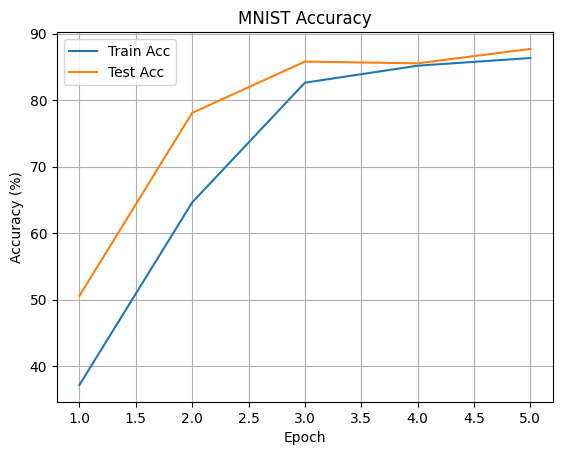

In [88]:
import matplotlib.pyplot as plt
import torch

def main():
    # 1) 从CSV拆分出子矩阵
    W_in, W_rec, visual_ids, brain_ids = load_connectome_and_split(
        anno_file='./data/science.add9330_data_s2.csv',
        conn_file='./data/ad_connectivity_matrix.csv'
    )
    hidden_size = len(brain_ids)
    input_size = 28 * 28
    output_size = 10

    # 2) 定义模型
    model = ResidualConnectomeRNN(
        W_in_init=W_in,
        W_rec_init=W_rec,
        # input_size=input_size,
        # hidden_size=hidden_size,
        # output_size=output_size,
        num_steps=10,
    )

    # 3) 准备MNIST
    train_loader, test_loader = get_mnist_loaders(batch_size=64)

    # 4) 训练
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    epochs = 5
    train_acc_list, test_acc_list = train_connectome_rnn(
        model, train_loader, test_loader,
        device=device,
        epochs=epochs,
        lr=1e-3
    )

    # 5) 画图
    x_axis = range(1, epochs+1)
    plt.plot(x_axis, train_acc_list, label='Train Acc')
    plt.plot(x_axis, test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('MNIST Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
